### Notebook to visualize FreeSurfer measaures on surfaces and parcellations

In [1]:
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from nibabel.freesurfer.mghformat import load
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import datasets, surface, plotting
import seaborn as sns
from pylab import *

In [2]:
### Load data
data_dir = f"/home/nikhil/projects/Parkinsons/nimhans/data/PD_SERB/"
session = "ses-01"

# imaging derivatives
FS_dir = f"{data_dir}/derivatives/freesurfer/v6.0.1/"
FS_surf_dir = f"{FS_dir}/surfmaps/{session}/"

### Surface and annotation files

- Possible surfaces: ["fsaverage", "fsaverage5"]
- Possible annot: 
    - "fsaverage": ["aparc", "aparc.a2009s", "Yeo2011_7Networks_N1000", "Yeo2011_17Networks_N1000"]
    - "fsaverage5": ["schaefer-500"]

In [3]:
template_surface = "fsaverage" # "fsaverage" or "fsaverage5"
annot = "aparc"

if template_surface == "fsaverage":
    fsaverage_dir = "/home/nikhil/projects/Parkinsons/qpn/derivatives/freesurfer/v6.0.1/output/ses-01/fsaverage/"
    annot_dir = f"{fsaverage_dir}/label/"
    
else:
    fsaverage_dir = "/home/nikhil/projects/neuroinformatics_tools/micapipe/surfaces/fsaverage5/"
    annot_dir = "/home/nikhil/projects/neuroinformatics_tools/micapipe/parcellations/"

surf_dir = f"{fsaverage_dir}/surf/"

pial_lh = read_surface(f"{surf_dir}/lh.pial", itype='fs')
pial_rh = read_surface(f"{surf_dir}/rh.pial", itype='fs')


if annot in ["aparc", "aparc.a2009s", "Yeo2011_7Networks_N1000", "Yeo2011_17Networks_N1000"]:
    annot_lh= f"{annot_dir}/lh.{annot}.annot"
    annot_rh= f"{annot_dir}/rh.{annot}.annot"
else:
    annot_lh= f"{annot_dir}/lh.{annot}_mics.annot"
    annot_rh= f"{annot_dir}/rh.{annot}_mics.annot"

labels = np.concatenate((nib.freesurfer.read_annot(annot_lh)[0], nib.freesurfer.read_annot(annot_rh)[0]), axis=0)

print(f"tempate surface: {template_surface}, annot: {annot}")
print(f"shape of concat array: {labels.shape}")

tempate surface: fsaverage, annot: aparc
shape of concat array: (327684,)


### Plot CT on surface

In [4]:
DX_groups = ["control","PD"] 
hemi_list = ["lh", "rh"]
fwhm = 10

surf_dict = {}
for grp in DX_groups:
    hemi_CT_list = []
    for j, hemi in enumerate(hemi_list):
        CT_img = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_{grp}_{fwhm}mm.mgh")
        avg_CT = np.squeeze(np.mean(CT_img.get_fdata(),axis=3))
        hemi_CT_list.append(np.expand_dims(avg_CT,1))
    
    surf_dict[grp] = np.squeeze(np.concatenate(hemi_CT_list, axis=0))


### Controls

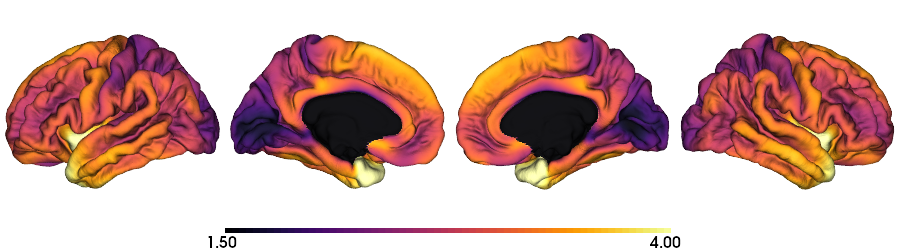

In [5]:
# Plot the surfaces
CTRL_surf = surf_dict["control"]
plot_hemispheres( pial_lh, pial_rh, array_name=CTRL_surf, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact",
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap="inferno", transparent_bg=True)


### Parkinsons

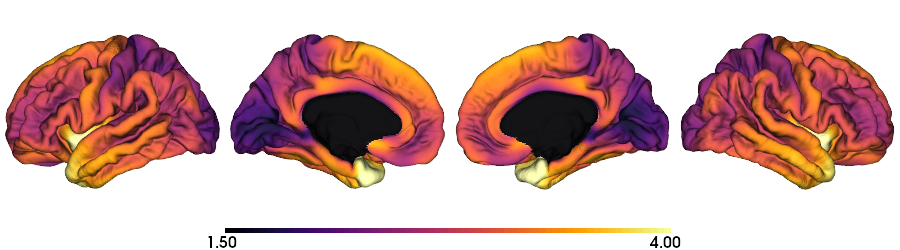

In [6]:
PD_surf = surf_dict["PD"]
plot_hemispheres( pial_lh, pial_rh, array_name=PD_surf, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact",
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap="inferno", transparent_bg=True)

### Difference between CTRL and PD

Plotting: (control - PD)


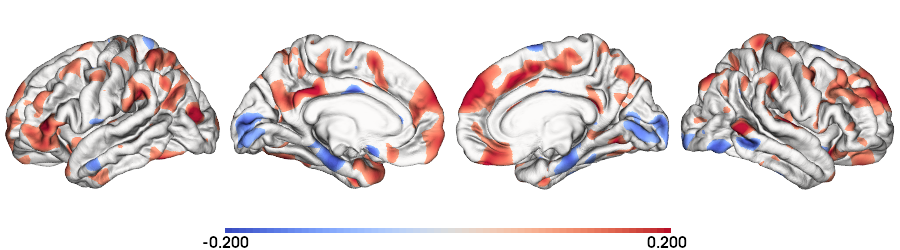

In [7]:
plot_thresh = 0.1
diff_surf = surf_dict["control"] - surf_dict["PD"]
diff_surf[(diff_surf < plot_thresh) & (diff_surf > -plot_thresh)] = 0

print("Plotting: (control - PD)")

plot_hemispheres( pial_lh, pial_rh, array_name=diff_surf, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact",
                 nan_color=(0, 0, 0, 1), color_range=(-0.2, 0.2), cmap="coolwarm", transparent_bg=True)

### Plot labels on the surface

Using aparc parcellation


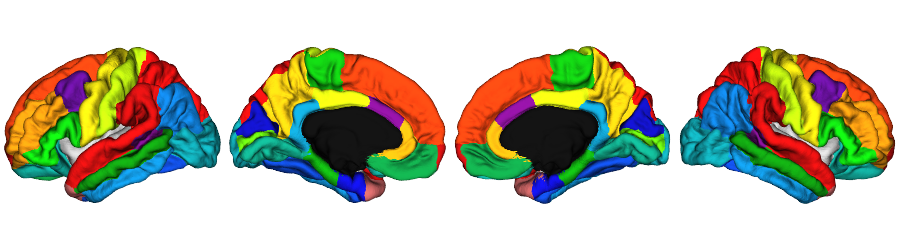

In [8]:
# plot labels on surface
print(f"Using {annot} parcellation")
plot_hemispheres(pial_lh, pial_rh, array_name=labels, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap='nipy_spectral', transparent_bg=True)

### Plot average CT per parcel

In [9]:
def get_mean_CT_per_parcel(labels, CT_vals, round_decimals=1):

    CT_parcel_df = pd.DataFrame()
    CT_parcel_df["CT"] = CT_vals
    CT_parcel_df["label"] = labels
    mean_CT_per_label_df = CT_parcel_df.groupby("label").mean().reset_index()
    label_CT_map_dict = dict(zip(mean_CT_per_label_df["label"], mean_CT_per_label_df["CT"]))
    CT_parcel_df["CT_parcel"] = CT_parcel_df["label"].replace(label_CT_map_dict)
    mean_CT_parcel = np.array(CT_parcel_df["CT_parcel"],dtype=np.float32).round(round_decimals)

    return mean_CT_parcel

### Controls

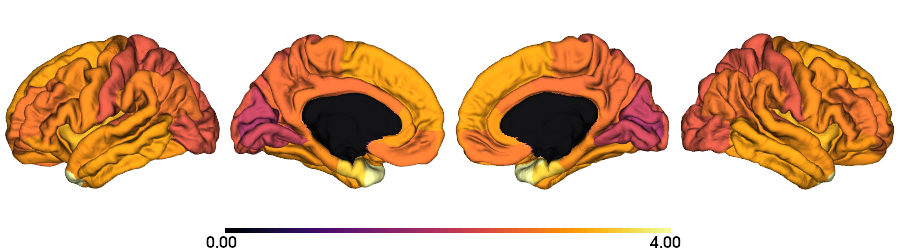

In [14]:
# plot mean CT per parcel on surface
plot_array = get_mean_CT_per_parcel(labels, CTRL_surf)
cmap = "inferno" #"Pastel2_r" #"inferno"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True,color_bar='bottom') #color_range=(1.5, 4)

### PD

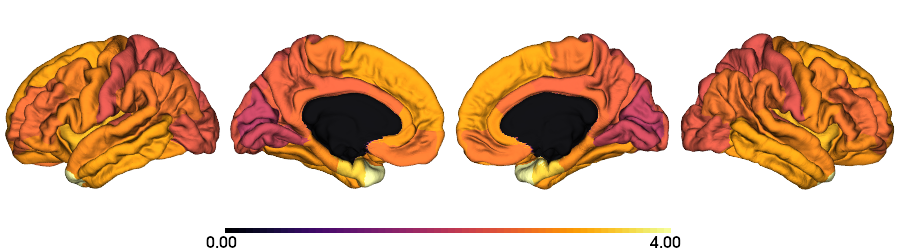

In [15]:
# plot mean CT per parcel on surface
plot_array = get_mean_CT_per_parcel(labels, PD_surf)
cmap = "inferno"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True, color_bar='bottom') #color_range=(1.5, 4),

### Difference between CTRL and PD

Plotting: (control - PD)


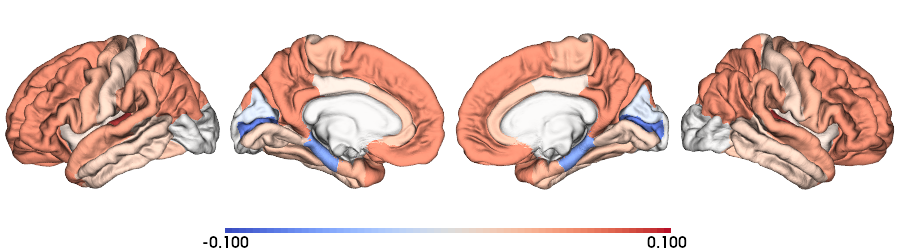

In [19]:
# plot mean CT per parcel on surface
plot_thresh = 0.05
diff_surf = surf_dict["control"] - surf_dict["PD"]
diff_surf[(diff_surf < plot_thresh) & (diff_surf > -plot_thresh)] = 0

print("Plotting: (control - PD)")

plot_array = get_mean_CT_per_parcel(labels, diff_surf, round_decimals=2)
color_range = (-0.1, 0.1) #(-max(abs(plot_array)), max(abs(plot_array)))
cmap = "coolwarm"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True, color_bar='bottom',color_range=color_range)

## CIHR braincharts plot (cartoon)

4.370330385863781 0.0
4.0 0.0
[0.0, 0.5, 1.9, 2.0, 2.1, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.3, 3.5, 4.0]
[-4.375, -3.75, -3.125, -2.5, -1.875, -1.25, -0.625, 0.0, 0.625, 1.25, 1.875, 3.125, 3.75, 4.375, 5.0]


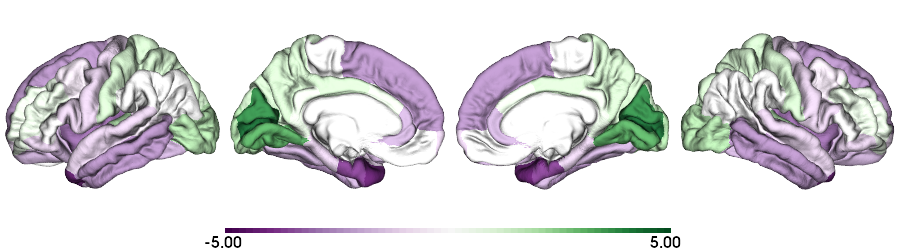

In [18]:
# plot mean CT per parcel on surface
PD_surf = surf_dict["PD"]
print(PD_surf.max(),PD_surf.min())
plot_array = get_mean_CT_per_parcel(labels, PD_surf)
print(plot_array.max(),plot_array.min())

unique_plot_vals = list(set(plot_array))
unique_plot_vals.sort()
print(unique_plot_vals)
n_unique_plot_vals = len(unique_plot_vals)
plot_vals_modulated = np.linspace(-0.5,0.5,n_unique_plot_vals)

for i, val in enumerate(unique_plot_vals):
    if i != 0:
        plot_array[plot_array == val] = plot_vals_modulated[-i] * 10

unique_plot_vals = list(set(plot_array))
unique_plot_vals.sort()
print(unique_plot_vals)
cmap = "PRGn" #inferno"
# cmap = cm.get_cmap('PiYG', n_unique_plot_vals) 
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True, color_bar='bottom',  layout_style="row",
                 color_range=(-5, 5))